In [1]:
#
# Things to add:
#
# A.) 1. Prepare and 3. Debrief
# B.) Word counts (for everything)
# C.) Spread for cycle metrics (box plots)
# D.) Cycle metrics over time
# E.) Make everything functions instead of loops.
#

In [2]:
#
# Steps to run:
#
# 1.) Run the Google Drive API Python Quickstart: https://developers.google.com/drive/api/v3/quickstart/python
# 2.) Run the Google Sheets API Python Quickstart: https://developers.google.com/sheets/api/quickstart/python
# 3.) Put this notebook in the same path as your token.json files.
# 4.) Make sure this notebook is calling the correct token.json files (in sheets_token_path and drive_token_path below).
# 5.) Run notebook!
#

In [3]:
#
# Notes:
#
# This is optimized for the Work Cycles v2.2 sheet.
#
# The following elements are hardcoded:
# A.) Filters sheets containing 'Ultraworking' in title.
# B.) Calls sheets by '1. Prepare', '2. Work', '3. Debrief'.
# C.) Extracting data and order of features.
#

In [4]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

# from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer

from IPython.display import display

In [5]:
# This runs the quickstart2.py, creating token.json (if you don't have it).
# !python /Users/sam/Desktop/projects/quickstart2.py

In [ ]:
# !pip install --upgrade google-api-python-client

In [6]:
# !pip install --upgrade oauth2client

In [11]:
# Get all Sheets using Google Drive API.

# # from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

item_df = []

page_token = None

store = file.Storage('./creds/token.json')
creds = store.get()
        
service = build('drive', 'v3', http=creds.authorize(Http()))

while True:
    
    # Gets all Sheets
    response = service.files().list(q = "mimeType = 'application/vnd.google-apps.spreadsheet'",
                                          fields = 'nextPageToken, files(name, id, createdTime)',
                                          pageToken = page_token).execute()
    
    for file in response.get('files', []):
        item_df.append(file)
        
    page_token = response.get('nextPageToken', None)
    
    if page_token is None:
        break
        
item_df[:5]

[{'id': '10T2jeqAj_RO0VIZgdXNv7-l62fbn5hyqQ0XRHE8CCV4',
  'name': '181209_2 Ultraworking - Work Cycles v2.2',
  'createdTime': '2018-12-09T23:42:43.086Z'},
 {'id': '1Ipegf_7bXHUB9eAeR10Vq0NKYgunQvRUzBPd2TEiHaY',
  'name': 'OKONOMIYAKI FUND',
  'createdTime': '2017-11-01T23:35:21.106Z'},
 {'id': '1v18V4rhPuMX2ItAMe9F7eWaIXPZebFAyC9a3eaCC3Ak',
  'name': 'Copy of [BLANK] Ultraworking - Work Cycles v2.2',
  'createdTime': '2018-12-09T23:43:21.627Z'},
 {'id': '1dX8220vLbrJ7u1iJqtqcPoEp5sM49vTXwld1EwqZyEw',
  'name': 'Copy of [BLANK] Ultraworking - Work Cycles v2.2',
  'createdTime': '2018-12-09T23:43:17.049Z'},
 {'id': '11CbJEQqbCheHDE1tMrZ8PSKvgxZyy2VqrcB7_lU7G8Y',
  'name': '181120 - Ultraworking Work Cycles v2.2',
  'createdTime': '2018-11-20T21:21:42.432Z'}]

In [12]:
# pretty up the df
items = pd.DataFrame(item_df)
items['createdTime'] = pd.to_datetime(items['createdTime'])
items = items[['name', 'id', 'createdTime']]

# filter to UW sheets
uw_df = items[items['name'].str.contains('Ultraworking')]
uw_df.reset_index(inplace=True, drop=True)

uw_df

,name,id,createdTime
0,181209_2 Ultraworking - Work Cycles v2.2,10T2jeqAj_RO0VIZgdXNv7-l62fbn5hyqQ0XRHE8CCV4,2018-12-09 23:42:43.086
1,Copy of [BLANK] Ultraworking - Work Cycles v2.2,1v18V4rhPuMX2ItAMe9F7eWaIXPZebFAyC9a3eaCC3Ak,2018-12-09 23:43:21.627
2,Copy of [BLANK] Ultraworking - Work Cycles v2.2,1dX8220vLbrJ7u1iJqtqcPoEp5sM49vTXwld1EwqZyEw,2018-12-09 23:43:17.049
3,181120 - Ultraworking Work Cycles v2.2,11CbJEQqbCheHDE1tMrZ8PSKvgxZyy2VqrcB7_lU7G8Y,2018-11-20 21:21:42.432
4,181209 Ultraworking - Work Cycles v2.2,1nB8KjuHbTuniKNIOHHLdwo_qeUPZNU0EGTxOBBa2f58,2018-11-21 20:59:56.959
5,181207 Ultraworking - Work Cycles v2.2,1qKjagIvP9QKbphTxgspMStsy9vQqCccsSOthWtuuvdQ,2018-12-06 10:03:57.695
6,181206 Ultraworking - Work Cycles v2.2,15SM7mB8Z8Xh1yBHBbfq0eSsL58yISnb0SMZqQyzhK-Q,2018-12-06 10:03:53.487
7,181206_2 Ultraworking - Work Cycles v2.2,1R9IrCBSYvnT_NOxihRnKWLD4KFF-GMKwi-7hwOF8l34,2018-12-06 10:04:03.589
8,181205_2 Ultraworking - Work Cycles v2.2,1fCoQz9Hvl-B1yzGpj2wQ_lco_okvDNVF_i1yI2GKXk0,2018-12-05 16:31:30.726
9,181205 Ultraworking - Work Cycles v2.2,140xc3jfQrwzV72LocXKQtcJcpsx4Va-j5hNrJcqQ0Ck,2018-12-05 10:23:30.999


In [ ]:
# # makes token_sheets.json if not already
# !python /Users/sam/Desktop/projects/quickstart_sheets.py

In [13]:
# Read work sheets from Google Sheets using ids.

# from __future__ import print_function
from googleapiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

# If modifying these scopes, delete the file token.json.
SCOPES = 'https://www.googleapis.com/auth/spreadsheets.readonly'

#
# Change this function to reference sheet 1., 2., 3. etc.
#

def main(spreadsheet_id, subsheet):
    
#     print(subsheet)
    
    store = file.Storage('./creds/token_sheets.json')
    creds = store.get()
        
    service = build('sheets', 'v4', http = creds.authorize(Http()))
    
    sheet_metadata = service.spreadsheets().get(spreadsheetId = spreadsheet_id).execute()
    sheets = sheet_metadata.get('sheets', '')
    
    #titles = [x.get("properties", {}).get("title") for x in sheets]
    
    # 2. Work
    
    SAMPLE_RANGE_NAME = '{}!A:J'.format(subsheet)
    
#     print(SAMPLE_RANGE_NAME)
    
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId = spreadsheet_id,
                                range = SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    
#     users = sheet_metadata['sheets'][0]['protectedRanges'][0]['editors']['users']
#     users = dict([users])
    
    return values

# values = main(SAMPLE_SPREADSHEET_ID)

In [14]:
# Map energy, morale, and completion to numeric.

energy_morale_dict = {
    'High': 2,
    'Medium': 1,
    'Low': 0
}

completion_dict = {
    'Yes': 2,
    'Half': 1,
    'No': 0
}

In [15]:
#
# This bit below works exclusively for sheet 2.
# Needs separate functions for sheet 1. and sheet 3.
#

In [16]:
# Concat all sheets.

main_df = pd.DataFrame()

for x in uw_df['id']:
        
    try:
        
        print('{}/{} - {}'.format(uw_df.loc[uw_df['id'] == x].index.values[0], len(uw_df), uw_df.loc[uw_df['id'] == x, 'name'].values[0]))

        values = main(x, '2. Work')

        contents = []

        for z in values:
            if len(z) > 1:
                contents.append(z[2:])
            else:
                pass
            
        # Underscores to distinguish metrics from vectorized strings.
        header = ['time_',
                  'cycle_',
                  'goal_',
                  'start_',
                  'hazards_',
                  'energy_',
                  'morale_',
                  'completion_',
                  'notes_',
                  'distractions_',
                  'improvements_']

        df = pd.DataFrame(contents).T
        df.columns = header
        
        df['energy_'] = df['energy_'].map(energy_morale_dict)
        df['morale_'] = df['morale_'].map(energy_morale_dict)
        df['completion_'] = df['completion_'].map(completion_dict)

        time = uw_df.loc[uw_df['id'] == x, 'createdTime'].values[0]
        df['timeCreated'] = [time]*len(df)
        df['timeCreated'] = pd.to_datetime(df['timeCreated'])

        main_df = pd.concat([main_df, df], axis=0)
    
    except:
        
        print(' ', 'Exception:', uw_df.loc[uw_df['id'] == x, 'name'].values[0])
        
main_df.reset_index(inplace=True, drop=True)
main_df.head()

0/14 - 181209_2 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
1/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
2/14 - Copy of [BLANK] Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
  Exception: Copy of [BLANK] Ultraworking - Work Cycles v2.2
3/14 - 181120 - Ultraworking Work Cycles v2.2
2. Work
2. Work!A:J
4/14 - 181209 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
5/14 - 181207 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
6/14 - 181206 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
7/14 - 181206_2 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
8/14 - 181205_2 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
  Exception: 181205_2 Ultraworking - Work Cycles v2.2
9/14 - 181205 Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
10/14 - TWG 5 Dec Demo Copy of Ultraworking - Work Cycles v2.2
2. Work
2. Work!A:J
11/14 - 181128 Ultraworking - Work Cycles v2.2
2. Work
2.

,time_,cycle_,goal_,start_,hazards_,energy_,morale_,completion_,notes_,distractions_,improvements_,timeCreated
0,6:30 PM,Cycle 1,Add word count metric to sheet 2. (If I finish...,jupyter,n/a,2.0,2.0,2.0,"Left computer charger at library, committing t...",n/a,n/a,2018-12-09 23:42:43.086
1,7:10 PM,Cycle 2,None,None,None,NaN,NaN,NaN,None,None,None,2018-12-09 23:42:43.086
2,7:50 PM,Cycle 3,None,None,None,NaN,NaN,NaN,None,None,None,2018-12-09 23:42:43.086
3,8:30 PM,Cycle 4,None,None,None,NaN,NaN,NaN,None,None,None,2018-12-09 23:42:43.086
4,9:10 PM,Cycle 5,None,None,None,NaN,NaN,NaN,None,None,None,2018-12-09 23:42:43.086


In [17]:
# Drops some features to make everything cleaner.
main_df.drop(
    [
        'start_', 
        'hazards_', 
        'distractions_', 
        'improvements_'
    ], 
    axis=1, 
    inplace=True
)

In [18]:
# Maps 'time' and 'cycle' to numeric values.
cycle_map = {
    'Cycle 1': 1,
    'Cycle 2': 2,
    'Cycle 3': 3,
    'Cycle 4': 4,
    'Cycle 5': 5,
    'Cycle 6': 6,
}

main_df['cycle_'] = main_df['cycle_'].map(cycle_map)
main_df['time_'] = pd.to_datetime(main_df['time_']).dt.time
main_df['hour_'] = [x.hour for x in main_df['time_']]

In [19]:
# Gets wordcount for features

def get_wordcount(feature):   
    wordcount_feature = []   
    for string in feature:       
        if string == None:
            wordcount = 0
        else:
            wordcount = len(string.split())
        wordcount_feature.append(wordcount)        
    return wordcount_feature
        
for x in [
    'goal_', 
    'notes_'
]:
    main_df[str(x) + 'wc_'] = get_wordcount(main_df[x])

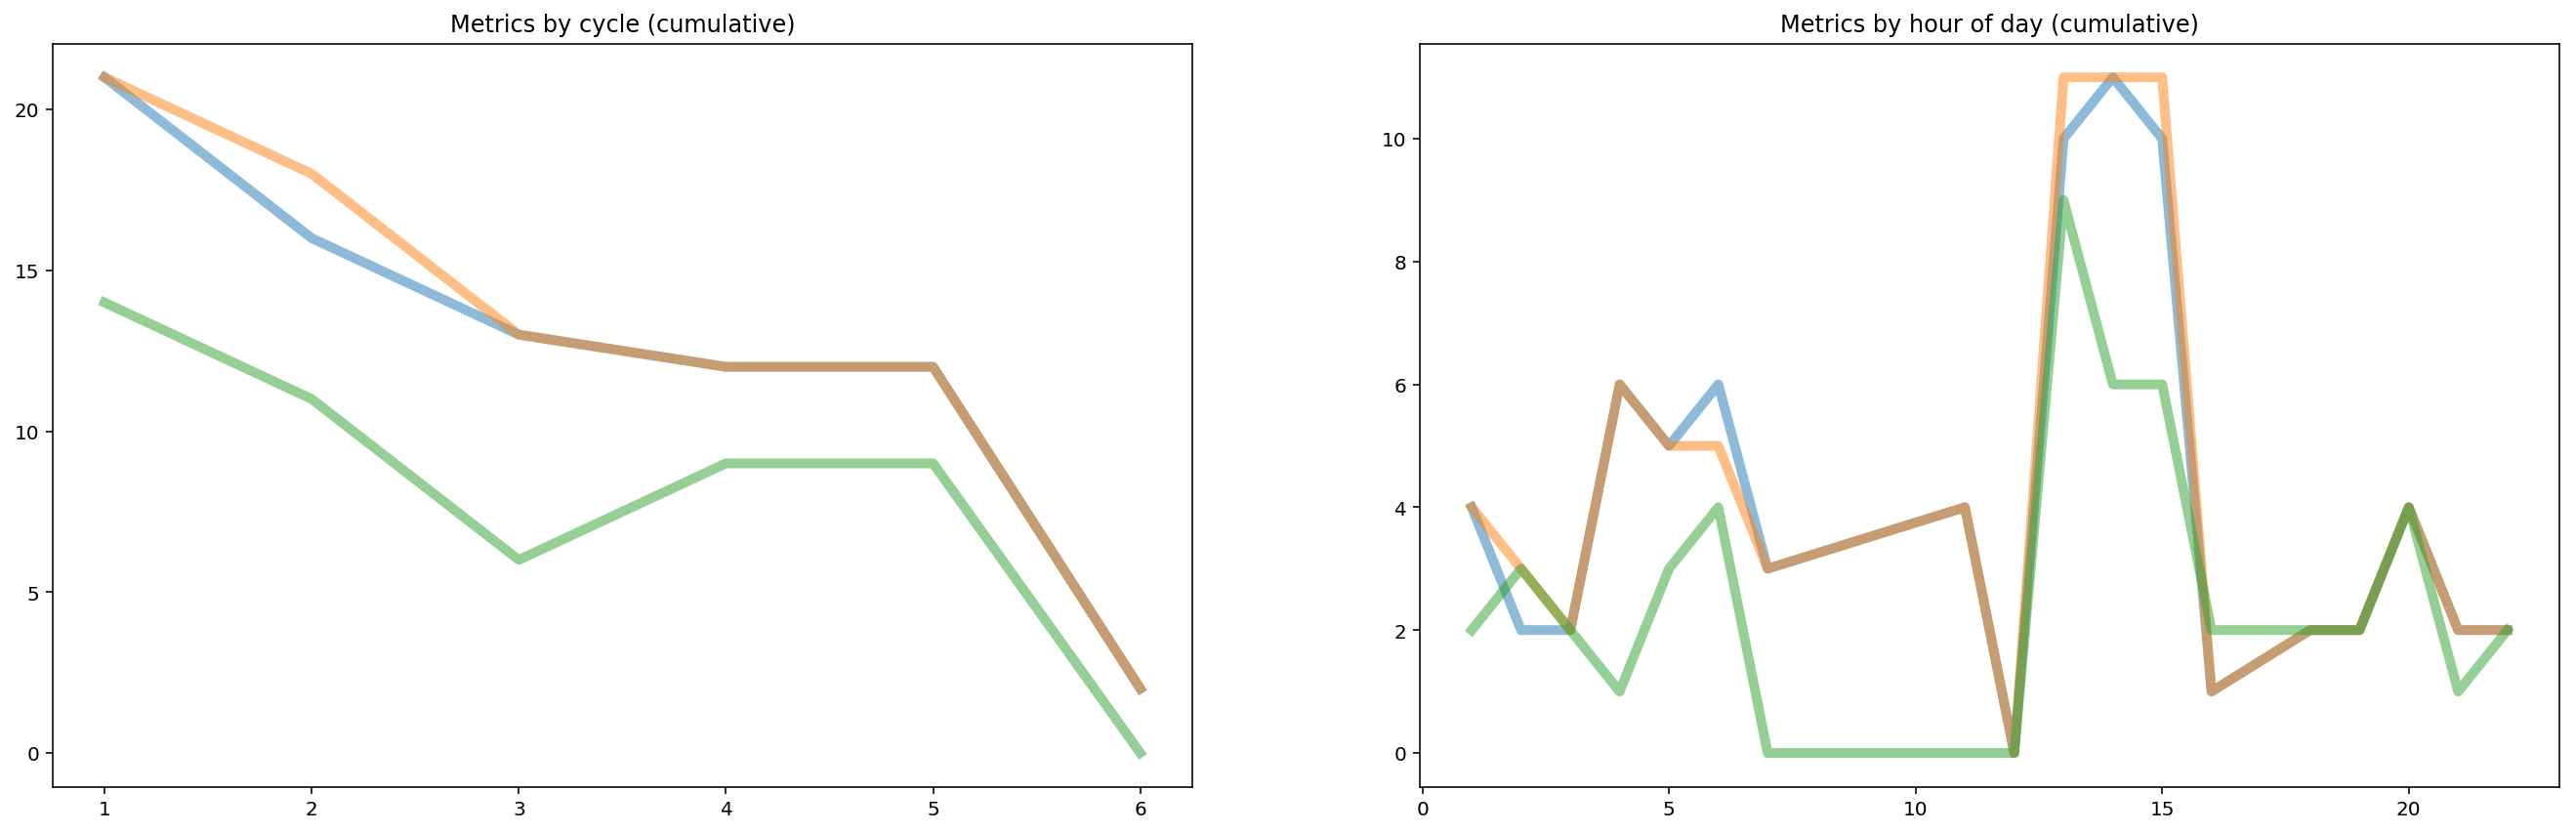

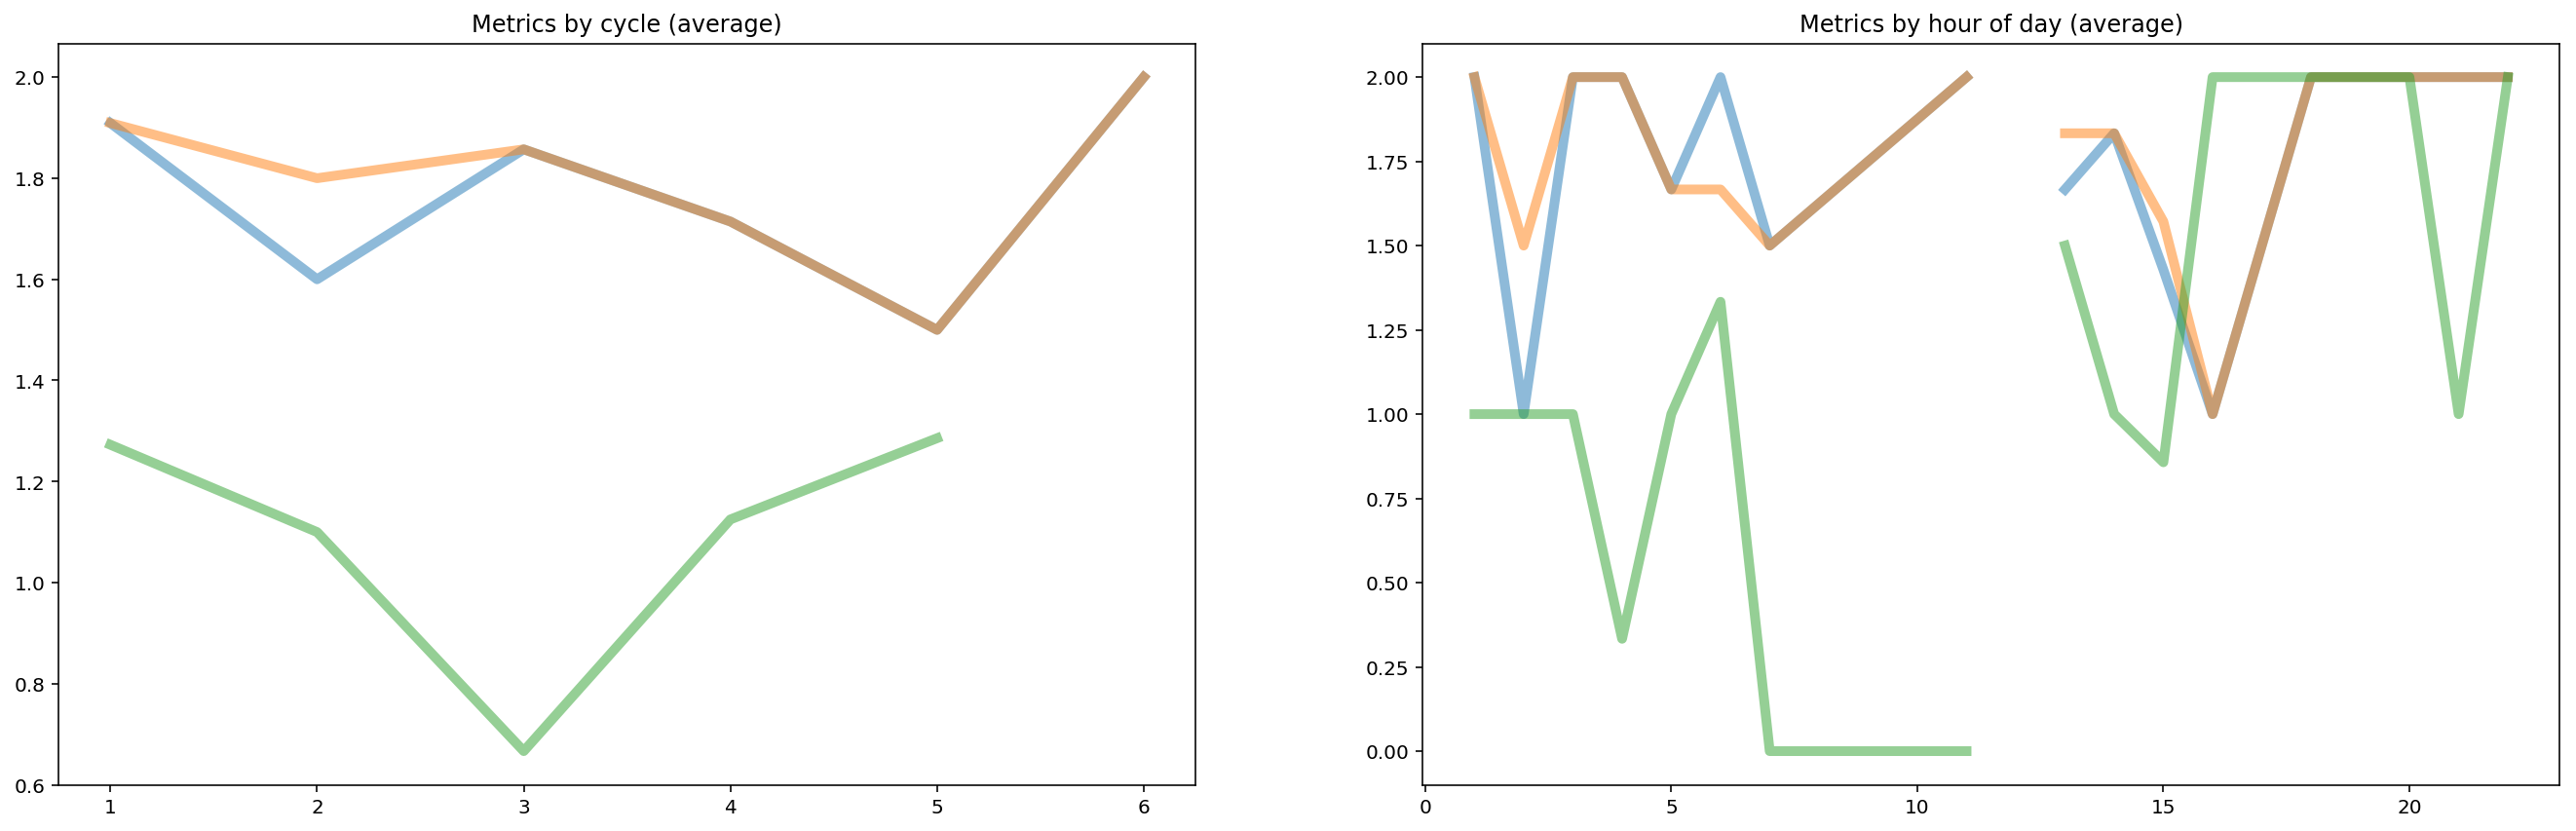

In [20]:
# Metrics over time

plt.figure(figsize=(23, 7))
# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').sum()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (cumulative)')
# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').sum()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (cumulative)')
plt.show()

plt.figure(figsize=(23, 7))
# sp1
plt.subplot(121)
plt.plot(main_df.groupby(by='cycle_').mean()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by cycle (average)')
# sp2
plt.subplot(122)
plt.plot(main_df.groupby(by='hour_').mean()[['energy_', 'morale_', 'completion_']], lw=5, alpha=.5)
plt.title('Metrics by hour of day (average)')
plt.show()

In [22]:
# 
# Add cycle spreads and cycle histories here.
# 




In [23]:
# Replaces null strings
def prep(string):
    if string == None:
        string = 'None'
    return string

# Gets stats
def get_stats(main_df_column, metric):
    
    corpus = [prep(i) for i in main_df[main_df_column]]
    vec = CountVectorizer(ngram_range=(1,1), 
                          stop_words='english')
    fit_vec = vec.fit_transform(corpus)
    vec_df = pd.DataFrame(fit_vec.todense(), columns=vec.get_feature_names())
    
    # Concat with metric
    goal_df = pd.concat([main_df[metric], vec_df], axis=1)
    new_df = goal_df.groupby(metric).sum().T
        
    metric_map = {
        0.0: 'low',
        1.0: 'medium',
        2.0: 'high'
    }
    
    new_df.columns = new_df.columns.map(metric_map)
        
    print('Keywords by {} for {}:'.format(metric, main_df_column))
    
    metric_df = pd.concat([pd.DataFrame(new_df.sort_values(by=x, ascending=False)[x].head(10)).rename_axis(x+'_kws').reset_index() for x in new_df.columns], axis=1)

    # Comment this out to remove total top keywords
    #metric_df = pd.concat([get_top(main_df_column), metric_df], axis=1)

    return metric_df
    
# Get top words 
def get_top(main_df_column):
    
    corpus = [prep(i) for i in main_df[main_df_column]]
    vec = CountVectorizer(ngram_range=(1,1), 
                          stop_words='english')
    fit_vec = vec.fit_transform(corpus)
    vec_df = pd.DataFrame(fit_vec.todense(), columns=vec.get_feature_names())
    
    return pd.DataFrame(vec_df.sum().sort_values(ascending=False).head(10), columns=['count']).rename_axis('top kws').reset_index()

In [26]:
# Print results

freeform = [
    'goal_',
#     'start_', 
#     'hazards_', 
    'notes_', 
#     'distractions_', 
#     'improvements_'
]

metrics = [
    'energy_',
    'morale_', 
    'completion_'
]

for x in freeform:
    for y in metrics: 
        display(get_stats(x, y))

Keywords by energy_ for goal_:


,low_kws,low,medium_kws,medium,high_kws,high
0,fucking,1,try,5,api,5
1,finish,1,code,3,print,5
2,sync,1,example,3,sheets,5
3,damn,1,image,2,run,4
4,finally,1,streaming,2,options,4
5,sql,1,design,2,list,4
6,model,1,ec2,2,strategy,3
7,allow,1,mounting,1,make,3
8,run,1,cycle,1,ec2,3
9,codecademy,1,potentially,1,code,3


Keywords by morale_ for goal_:


,medium_kws,medium,high_kws,high
0,run,2,api,5
1,code,2,sheets,5
2,finish,2,print,5
3,work,2,ec2,4
4,try,2,options,4
5,streaming,2,list,4
6,image,2,make,4
7,example,2,try,4
8,design,2,code,4
9,notebook,1,check,3


Keywords by completion_ for goal_:


,low_kws,low,medium_kws,medium,high_kws,high
0,model,4,make,3,expenses,2
1,print,4,options,3,finish,2
2,sheets,3,code,3,stuff,2
3,figure,3,try,3,example,2
4,options,3,strategy,3,reconcile,2
5,run,3,filter,3,code,2
6,delta,3,check,2,ec2,2
7,api,2,doc,2,dte,2
8,filter,2,connect,2,drive,2
9,ec2,2,upwork,2,streaming,2


Keywords by energy_ for notes_:


,low_kws,low,medium_kws,medium,high_kws,high
0,space,2,ec2,3,got,9
1,ec2,2,did,3,google,5
2,did,1,started,2,finished,5
3,halfway,1,mounted,2,started,5
4,cutting,1,s3,2,credentials,4
5,trying,1,got,2,api,4
6,shit,1,currently,2,did,3
7,sleep,1,like,2,doing,3
8,going,1,forward,2,drive,3
9,ran,1,cycle,1,cycle,3


Keywords by morale_ for notes_:


,medium_kws,medium,high_kws,high
0,did,4,got,10
1,ec2,4,finished,5
2,forward,3,started,5
3,moved,2,credentials,4
4,tried,2,google,4
5,sync,2,figured,3
6,started,2,cycle,3
7,space,2,api,3
8,minutes,2,s3,3
9,right,1,doing,3


Keywords by completion_ for notes_:


,low_kws,low,medium_kws,medium,high_kws,high
0,got,4,got,6,finished,4
1,ec2,3,did,4,got,4
2,issues,2,started,3,started,4
3,api,2,just,3,google,3
4,going,2,finished,2,credentials,3
5,tried,2,idea,2,shit,2
6,closest,2,forward,2,different,2
7,trying,2,ec2,2,good,2
8,cycle,2,thing,2,s3,2
9,shit,2,finish,2,api,2


In [25]:
main_df

,time_,cycle_,goal_,energy_,morale_,completion_,notes_,timeCreated,hour_,goal_wc_,notes_wc_
0,18:30:00,1,Add word count metric to sheet 2. (If I finish...,2.0,2.0,2.0,"Left computer charger at library, committing t...",2018-12-09 23:42:43.086,18,17,12
1,19:10:00,2,None,NaN,NaN,NaN,None,2018-12-09 23:42:43.086,19,0,0
2,19:50:00,3,None,NaN,NaN,NaN,None,2018-12-09 23:42:43.086,19,0,0
3,20:30:00,4,None,NaN,NaN,NaN,None,2018-12-09 23:42:43.086,20,0,0
4,21:10:00,5,None,NaN,NaN,NaN,None,2018-12-09 23:42:43.086,21,0,0
5,13:50:00,1,Get image streaming working,1.0,1.0,1.0,"I felt like I moved the ball forward, I did no...",2018-11-20 21:21:42.432,13,4,35
6,14:30:00,2,Continue with the example image streaming code...,1.0,1.0,2.0,"Finished example code, haven't implemented ful...",2018-11-20 21:21:42.432,14,9,7
7,15:10:00,3,Run on full set,2.0,2.0,0.0,"Ran into problems with train/test, spent much ...",2018-11-20 21:21:42.432,15,4,20
8,15:50:00,4,Keep debugging train test gen,2.0,2.0,2.0,Breakthrough shit,2018-11-20 21:21:42.432,15,5,2
9,16:30:00,5,"Finish e-mail (open Apex e-mails, click throug...",1.0,1.0,2.0,None,2018-11-20 21:21:42.432,16,14,0
